In [1]:
import numpy as np
import random

import h5py.highlevel
import astropy.io.fits as fits
from astropy.table import Table

import pandas as pd
import seaborn as sns
sns.set(style="ticks", context="talk", font_scale=1.)

import os
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: H5pyDeprecationWarning: The h5py.highlevel module is deprecated, code should import directly from h5py, e.g. 'from h5py import File'.
  after removing the cwd from sys.path.


In [2]:
## get data, including adding noise
def _getData(filename, lower, upper, redshifted=False, addNoise=False):
    obj=fits.open(filename)    
    data = Table.read(obj, hdu=1).to_pandas()
    z = Table.read(obj,hdu=2)['Z'].item()
    zErr = Table.read(obj,hdu=2)['Z_ERR'].item()
#    if zErr > 0.1*z:
#        print(filename,' Z=',z,' zErr=',zErr)
#        continue
    data['lam'] = np.power(10,data['loglam'])
    if redshifted:
        data['lam'] = data['lam']/(1+z)
    data = data[(data['lam']>lower) & (data['lam']<upper)]
    lam = np.linspace(lower,upper,upper-lower+1)
    flux = np.interp(lam, data['lam'], data['flux'])
    
    ## add noise 
    if addNoise:
        factor = np.random.uniform(low=0.2, high=1.0) # scale factor of std
        noise = np.random.normal(0, flux.std()*factor, len(flux))
        flux = flux+noise
    if not addNoise:
        factor = 0
    # normalize data
    std = np.std(flux)
    avg = np.mean(flux)
    eps = 0.001
    fluxNormalized = (flux - avg)/std
    fluxNormalized -= np.min(fluxNormalized)
    fluxNormalized += eps
    fluxNormalized /= np.max(fluxNormalized)
    dataSelected = pd.DataFrame({'lam': lam, 'flux': flux, 'fluxNormalized': fluxNormalized})

    _writefile(filename,dataSelected,z,lower, upper, factor)
    return dataSelected, z

def add_noise(flux):
    # normalize data
    std = np.std(flux)
    avg = np.mean(flux)
    eps = 0.001
    fluxNormalized = (flux - avg)/std
    fluxNormalized -= np.min(fluxNormalized)
    fluxNormalized += eps
    fluxNormalized /= np.max(fluxNormalized)
    dataSelected = pd.DataFrame({'fluxNoise': flux, 'fluxNoiseNormalized': fluxNormalized})
    _writefile(filename,dataSelected,z,lower, upper)
    return 


def _writefile(filename,data,z,lower, upper, factor=0):
    name = os.path.splitext(filename)[0]
    if (factor !=0):
        factor =str(np.round(factor,3))
        outputName = name+'-Noise'+factor+'-'+str(int(lower))+'-'+str(int(upper))+'_raw.csv'
    else:
        outputName = name+'-'+str(int(lower))+'-'+str(int(upper))+'_raw.csv'
    f = open(outputName,'w')
    f.write('# Original file: '+str(filename)+'\n')
    f.write('# wavelength range from: '+str(lower)+' to '+str(upper)+'\n')
    f.write('# redshift: '+str(z) +'\n')
    data.to_csv(f)
    f.close()

## Example 

good example of 1.9: spec-0330-52370-0304.fits

No handles with labels found to put in legend.


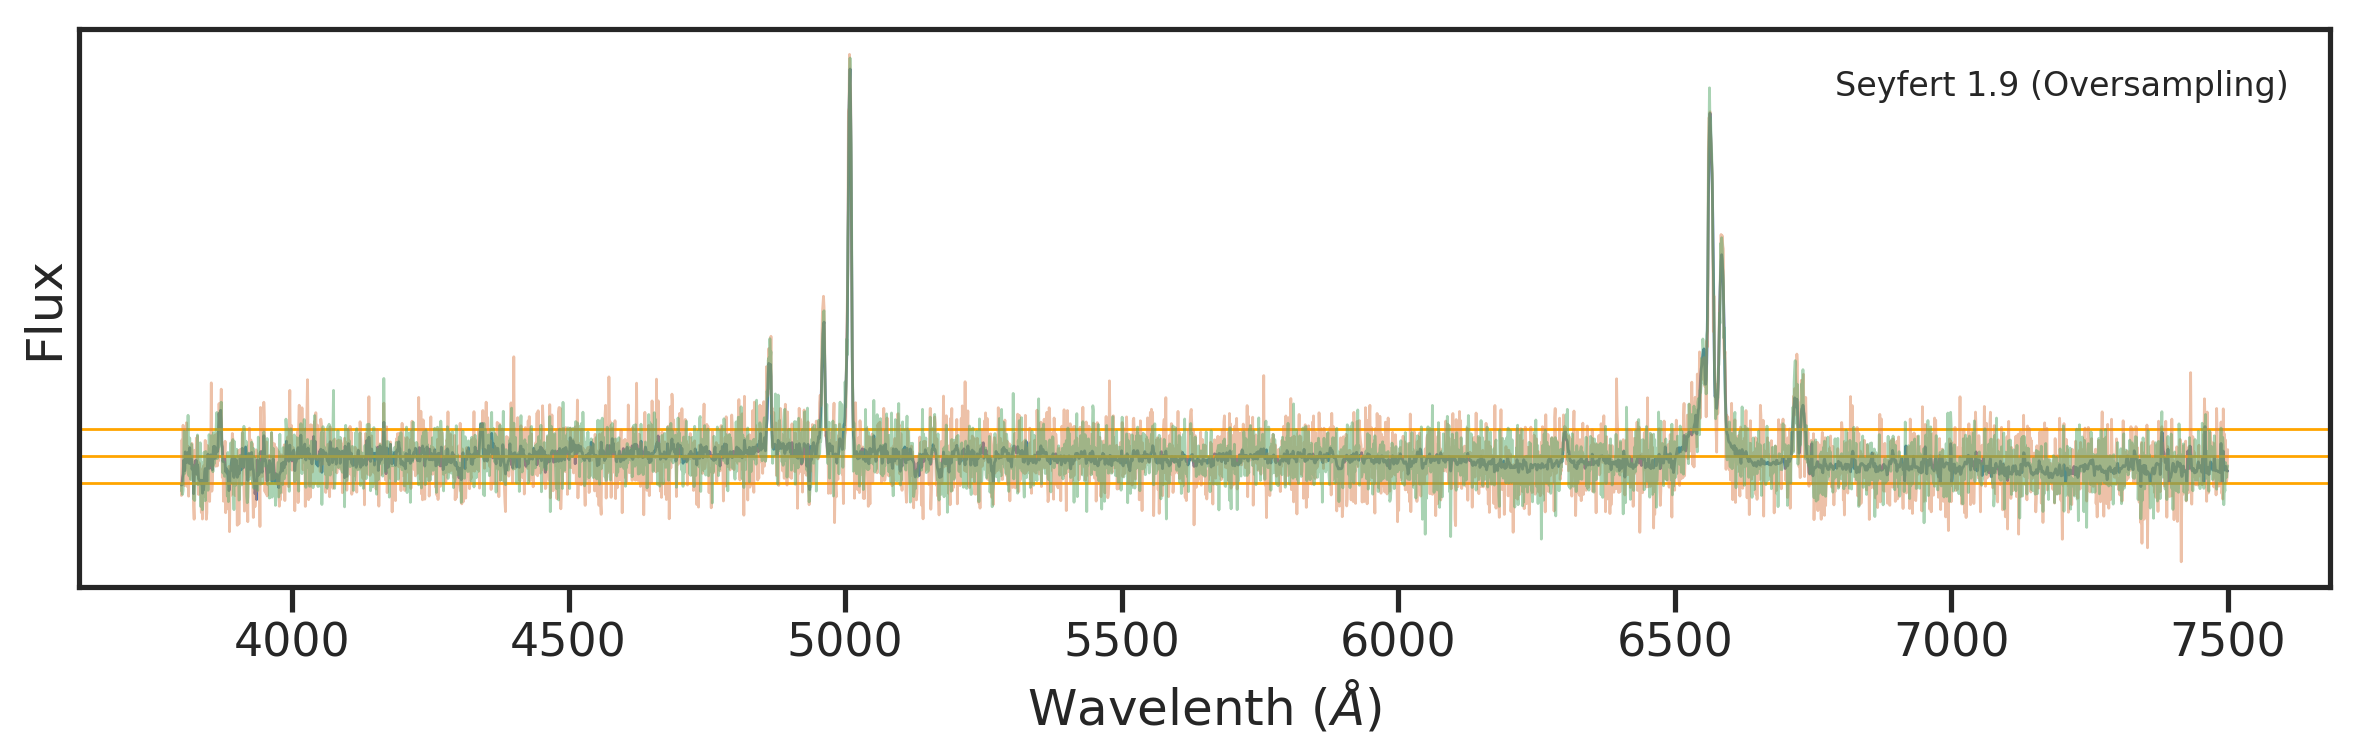

In [3]:
fig = plt.figure(figsize=(12,4))

example, z = _getData('./Sy19_test/spec-0330-52370-0304.fits', lower=3800, upper=7500, redshifted=True, addNoise=False)

plt.plot(example['lam'],example['flux'],linewidth=1,label='')
plt.axhline(y=example['flux'].mean(),linewidth=1,color='orange')
plt.axhline(y=example['flux'].mean()+example['flux'].std(),linewidth=1,color='orange')
plt.axhline(y=example['flux'].mean()-example['flux'].std(),linewidth=1,color='orange')

example, z = _getData('./Sy19_test/spec-0330-52370-0304.fits', lower=3800, upper=7500, redshifted=True, addNoise=True)
plt.plot(example['lam'],example['flux'],alpha=0.5,linewidth=1,label='')

example, z = _getData('./Sy19_test/spec-0330-52370-0304.fits', lower=3800, upper=7500, redshifted=True, addNoise=True)
plt.plot(example['lam'],example['flux'],alpha=0.5,linewidth=1,label='')

plt.yticks([], [])

plt.legend(title='Seyfert 1.9 (Oversampling)',frameon=False)
plt.xlabel('Wavelenth ($\AA$)')
plt.ylabel('Flux')

fig.tight_layout()
plt.savefig('example_seyfert19_spectrum.pdf', format='pdf')

No handles with labels found to put in legend.


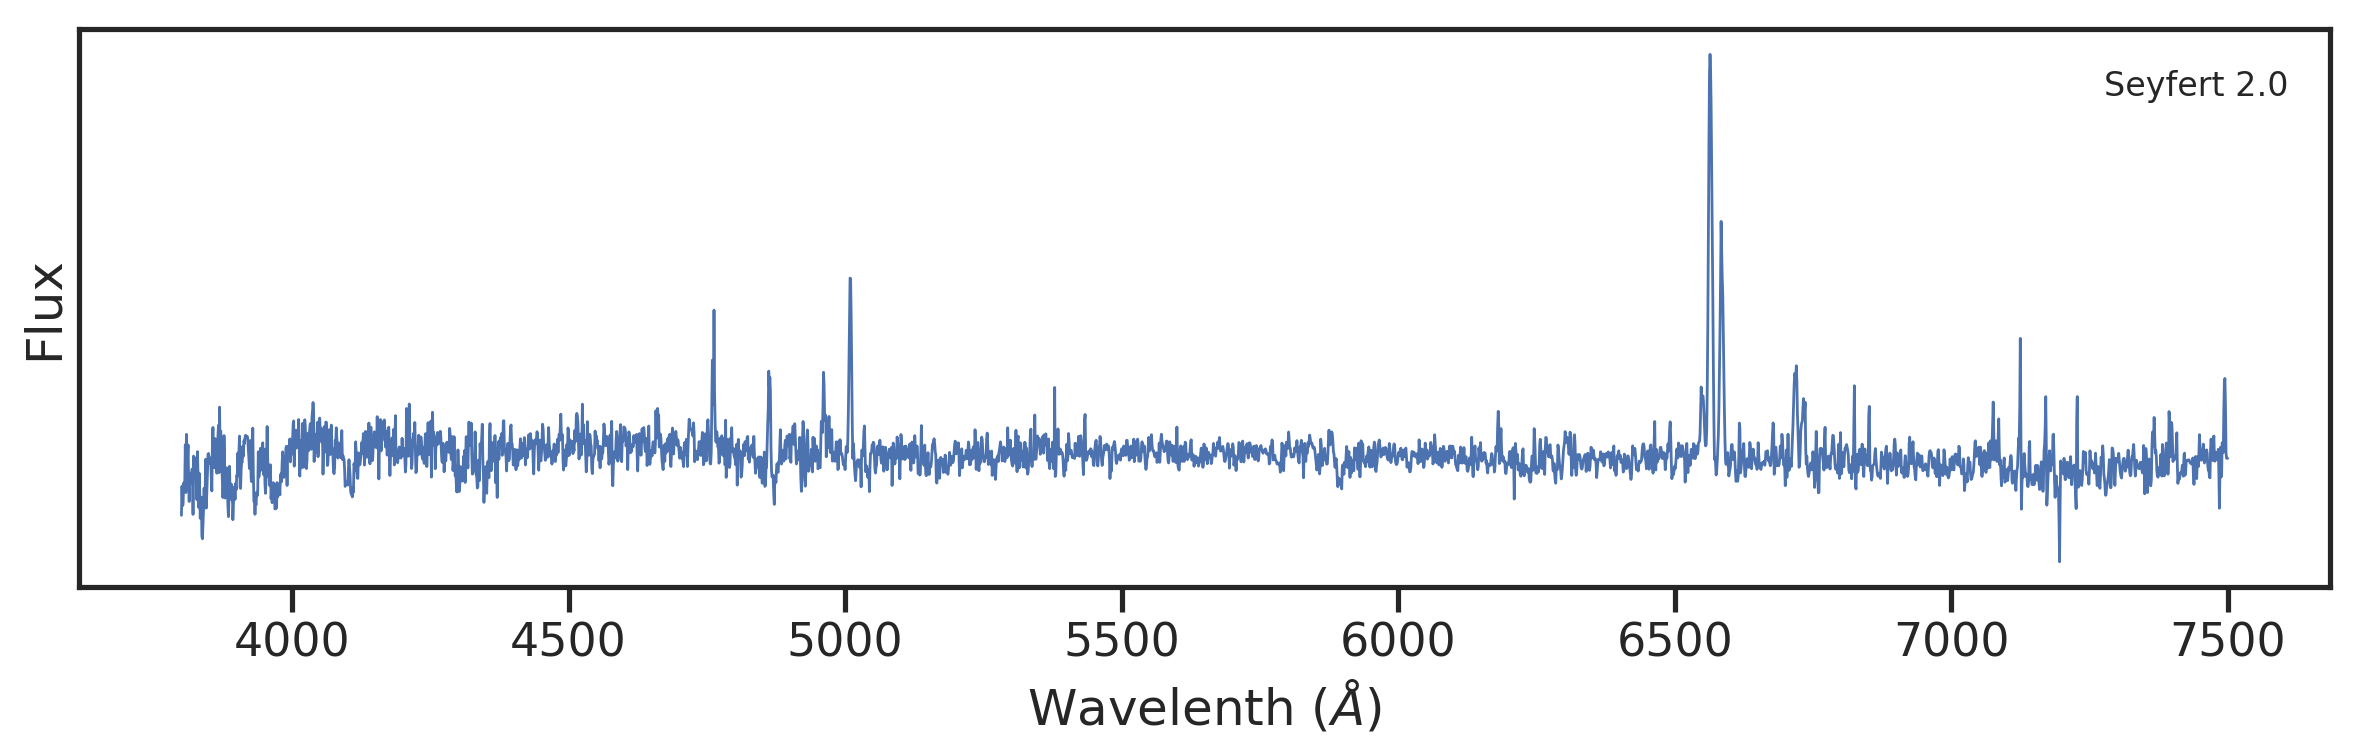

In [4]:
fig = plt.figure(figsize=(12,4))

example, z = _getData('./Sy20_test/spec-1351-52790-0130.fits', lower=3800, upper=7500, redshifted=True, addNoise=False)

plt.plot(example['lam'],example['flux'],linewidth=1,label='')
#plt.axhline(y=example['flux'].mean(),linewidth=1,color='orange')
#plt.axhline(y=example['flux'].mean()+example['flux'].std(),linewidth=1,color='orange')
#plt.axhline(y=example['flux'].mean()-example['flux'].std(),linewidth=1,color='orange')


plt.yticks([], [])

plt.legend(title='Seyfert 2.0',frameon=False)
plt.xlabel('Wavelenth ($\AA$)')
plt.ylabel('Flux')


fig.tight_layout()
plt.savefig('example_seyfert20_spectrum.pdf', format='pdf')

# over-sampling Sy1.9

In [96]:
for i in range(10):
    folder = 'Sy19_test'
    filenames = [x for x in os.listdir(folder) if x.endswith(".fits")]
    pixels = []
    zs = []
    
    for filename in filenames:
        print(filename)
        data, z = _getData('./'+folder+'/'+filename, lower=3800, upper=7500, redshifted=True, addNoise=True)
        pixels.append(data['fluxNormalized'].tolist())
        zs.append(z)
    
    pixels = np.asarray(pixels).flatten()
    zs = np.asarray(zs).flatten()
    csvfilename = 'sy19-test-pixels-3800-7500-redshifted-normalized-noise.'+str(i)+'.csv'
    pixels.tofile(csvfilename, sep=",")
    #zs.tofile('sy19-test-zs-3800-7500-redshifted-normalized.csv', sep=",")

In [97]:
for i in range(10):
    folder = 'Sy19_train'
    filenames = [x for x in os.listdir(folder) if x.endswith(".fits")]
    pixels = []
    zs = []
    
    for filename in filenames:
        print(filename)
        data, z = _getData('./'+folder+'/'+filename, lower=3800, upper=7500, redshifted=True, addNoise=True)
        pixels.append(data['fluxNormalized'].tolist())
        zs.append(z)
    
    pixels = np.asarray(pixels).flatten()
    zs = np.asarray(zs).flatten()
    csvfilename = 'sy19-pixels-3800-7500-redshifted-normalized-noise.'+str(i)+'.csv'
    pixels.tofile(csvfilename, sep=",")
    #zs.tofile('sy19-test-zs-3800-7500-redshifted-normalized.csv', sep=",")

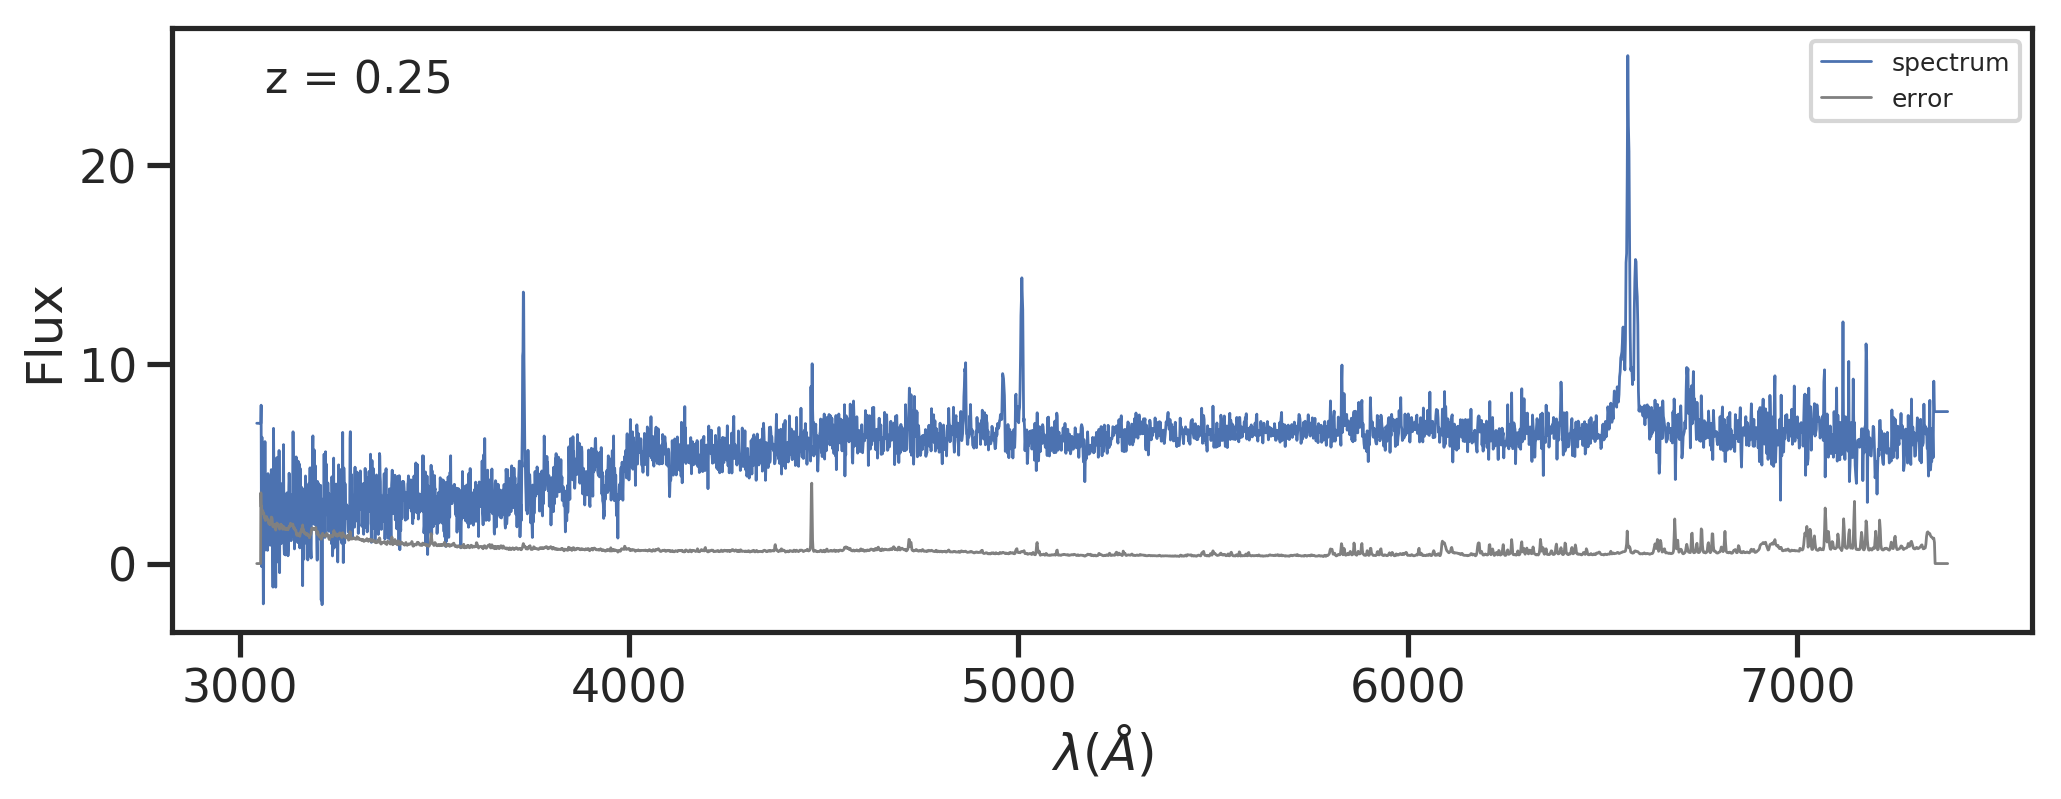

In [72]:
# Author: Jake VanderPlas <vanderplas@astro.washington.edu>
# License: BSD
#   The figure is an example from astroML: see http://astroML.github.com
from matplotlib import pyplot as plt
from astroML.datasets import fetch_sdss_spectrum
from astroML.datasets.tools import SDSSfits

#------------------------------------------------------------
# Fetch single spectrum
#plate = 1351
#mjd = 52790
#fiber = 130
#
#spec = fetch_sdss_spectrum(plate, mjd, fiber)
spec = SDSSfits('./SDSS/galaxy/spSpec-54553-1670-256.fit')

#------------------------------------------------------------
# Plot the resulting spectrum
fig = plt.figure(figsize=(12,4))
ax = plt.axes()
ax.plot(spec.wavelength()/(1+spec.z), spec.spectrum, '-', label='spectrum',linewidth=1)
ax.plot(spec.wavelength()/(1+ spec.z), spec.error, '-', color='gray', label='error',linewidth=1)

ax.legend(loc=1,fontsize=9)

#ax.set_title('Plate = %(plate)i, MJD = %(mjd)i, Fiber = %(fiber)i' % locals())

ax.text(0.05, 0.95, 'z = %.2f' % spec.z, size=16,
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlabel(r'$\lambda (\AA)$')
ax.set_ylabel('Flux')
#ax.set_xlim(3600, 7500)
#ax.set_ylim(-10, 300)

plt.show()

In [73]:
spec

In [70]:
obj=fits.open('./SDSS/galaxy/spSpec-54553-1670-256.fit')
data = Table.read(obj, hdu=4).to_pandas()
#z = Table.read(obj,hdu=2)['Z'].item()
#data['lam'] = np.power(10,data['loglam'])

In [71]:
data

,temp_no,peak_no,shift,z,zErr,r,con,height,width,widthErr,delta,rms
0,0,0,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9997.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000,-9999.000000
1,1,0,43.223225,0.005348,0.000551,0.503481,0.001787,0.016552,866.593750,-9999.0,2.362749,0.032875
2,2,0,12.975841,-0.003909,0.000524,0.546949,0.001968,0.022275,852.175537,-9999.0,2.258151,0.040725
3,3,0,21.548475,-0.002408,0.000660,0.557725,0.002015,0.018899,1082.179810,-9999.0,2.847795,0.033887
4,4,0,12.508179,-0.002473,0.000718,0.641997,0.002429,0.021864,1244.064331,-9999.0,3.105778,0.034056
5,5,0,15.507589,-0.002270,0.000537,0.548975,0.001976,0.022157,877.268311,-9999.0,2.321603,0.040360
6,6,0,7.906021,-0.001579,0.000553,0.502585,0.001783,0.019140,877.430054,-9999.0,2.393721,0.038084
7,7,0,10.917152,-0.001723,0.000384,0.484030,0.001711,0.020177,601.267151,-9999.0,1.660829,0.041685
8,8,0,14.139856,-0.001869,0.000314,0.482017,0.001704,0.019555,489.636658,-9999.0,1.354318,0.040569
9,9,0,23.634190,-0.001535,0.000301,0.273625,0.001073,0.011592,403.158905,-9999.0,1.297581,0.042364


In [77]:
spec.wavelength().tolist()

[3800.143529415859,
 3801.0186455476696,
 3801.8939632056126,
 3802.7694824361047,
 3803.6452032855573,
 3804.521125800408,
 3805.397250027089,
 3806.2735760120595,
 3807.150103801774,
 3808.026833442713,
 3808.9037649813513,
 3809.7808984641915,
 3810.65823393773,
 3811.5357714484903,
 3812.4135110429906,
 3813.2914527677754,
 3814.169596669385,
 3815.047942794385,
 3815.926491189337,
 3816.8052419008277,
 3817.684194975441,
 3818.563350459785,
 3819.4427084004683,
 3820.322268844109,
 3821.202031837349,
 3822.0819974268243,
 3822.9621656591976,
 3823.8425365811263,
 3824.7231102392952,
 3825.6038866803838,
 3826.484865951097,
 3827.366048098136,
 3828.2474331682283,
 3829.1290212080958,
 3830.010812264487,
 3830.8928063841463,
 3831.7750036138436,
 3832.6574040003447,
 3833.540007590441,
 3834.4228144309195,
 3835.3058245685934,
 3836.1890380502755,
 3837.0724549227884,
 3837.956075232978,
 3838.8398990276855,
 3839.723926353778,
 3840.6081572581174,
 3841.4925917875935,
 3842.377229

In [78]:
spec.spectrum.tolist()

[7.038700103759766,
 7.038320064544678,
 7.03794002532959,
 7.037559986114502,
 7.037179946899414,
 7.036799907684326,
 7.036419868469238,
 7.036049842834473,
 7.035669803619385,
 7.035299777984619,
 7.0349202156066895,
 7.034550189971924,
 7.034180164337158,
 7.033810138702393,
 7.033430099487305,
 7.033060073852539,
 7.945219993591309,
 1.9502400159835815,
 -0.15264900028705597,
 6.340829849243164,
 -0.11633899807929993,
 2.6246399879455566,
 2.2638399600982666,
 0.800475001335144,
 -2.0231099128723145,
 -1.1684800386428833,
 3.0729100704193115,
 0.6381769776344299,
 1.8888700008392334,
 0.7534369826316833,
 6.1179399490356445,
 1.3682600259780884,
 3.472630023956299,
 1.8005800247192383,
 0.9678739905357361,
 2.924459934234619,
 0.9155049920082092,
 1.5878700017929077,
 2.1756300926208496,
 0.6617310047149658,
 1.9224499464035034,
 4.512080192565918,
 3.4689600467681885,
 1.7745200395584106,
 1.303380012512207,
 2.4415700435638428,
 4.129350185394287,
 1.8749899864196777,
 4.3378601

In [74]:
spec = SDSSfits('./SDSS/galaxy/spSpec-54553-1670-256.fit')

In [75]:
len(spec.wavelength())

3851

In [76]:
len(spec.spectrum)

3851